#### 1.设置图像参数，输出高清图像

In [1]:
## 在jupyter notebook中，该指令可有效提高图像画质
%config InlineBackend.figure_format = 'retina'
## magic function
## 在jupyter notebook中使用，功能是可以内嵌绘图
%matplotlib inline

import matplotlib
## 图像显示中文命令
matplotlib.rcParams['axes.unicode_minus']=False

## 设置绘图风格
import seaborn as sns 
sns.set(font= "Consolas",style="whitegrid",font_scale=1.4)

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# 导入评价函数库
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,roc_curve,auc,confusion_matrix

import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as Data
from torchtext.legacy import data
from torchtext.vocab import Vectors

D:\Program Files\anaconda3\envs\pytorch\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### 2.使用torchtext库准备网络需要的数据

##### (1) Field

In [3]:
## 使用torchtext库进行数据准备
# 定义文件中对文本和标签所要做的操作
"""
sequential=True:(是否把数据表示成序列)表明输入的文本是字符，而不是数值字
tokenize=mytokenize:使用自定义的切词方法，利用空格切分词语
include_lengths:是否返回一个已经补全的最小batch的元组和和一个包含每条数据长度的列表
use_vocab=True: 创建一个词汇表
batch_first=True: batch优先的数据方式
fix_length=15 :每个句子固定长度为20,过长截取，过短补充
"""
## 定义文本切分方法，因为前面已经做过处理，所以直接使用空格切分即可
mytokenize = lambda x: x.split()
TEXT = data.Field(sequential=True, tokenize=mytokenize, 
                  include_lengths=True, use_vocab=True,
                  batch_first=True, fix_length=20)
LABEL = data.Field(sequential=False, use_vocab=False, 
                   pad_token=None, unk_token=None)

##### (2) TabularDataset.splits

In [4]:
## 对所要读取的数据集的列进行处理
## TabularDataset的参数fields要求是一个包含很多个tuple的list[(name, field),...]
text_data_fields = [
    ("labelcode", LABEL), # 对标签的操作
    ("cutword", TEXT) # 对文本的操作
]
## 读取训练集，验证集和测试集
traindata,valdata,testdata = data.TabularDataset.splits(
    path="data-derived", format="csv", 
    train="train.csv", fields=text_data_fields, 
    validation="val.csv",
    test = "test.csv", skip_header=True
)

In [5]:
## 查看划分好的三个数据集长度
print(len(traindata),len(valdata),len(testdata))
## 查看各个数据集各有多少个词
trainset = set()
valset = set()
testset = set()
for em in traindata:
    tmp = set(em.cutword)
    trainset.update(tmp)
for em in valdata:
    tmp = set(em.cutword)
    valset.update(tmp)
for em in testdata:
    tmp = set(em.cutword)
    testset.update(tmp)
print(len(trainset),len(valset),len(testset))

8517 2070 10141
18238 8763 21272


In [6]:
## 检查一个样本的标签和文本
em = traindata.examples[0]
print(em.labelcode)
print(em.cutword)

0
['西湖', '之声', '腾讯', '如懿传', '道歉', '这部', '亿大剧', '上映', '第一天', '遭', '网友', '狂吐槽', '愣', '拍成', '村头', '恋曲']


##### (3) build_vocab

In [7]:
## 使用训练集构建词典,没有预训练的词向量
## max_size不设置，vectors不设置
TEXT.build_vocab(traindata,vectors = None)
LABEL.build_vocab(traindata)
print("词典的词数:",len(TEXT.vocab.itos))
print("前10个单词:\n",TEXT.vocab.itos[0:10])
## 类别标签的数量和类别
print("训练集类别标签情况:",LABEL.vocab.freqs)

## 前两个分别代表示词典中没有的词语和用于填充的词语

词典的词数: 18240
前10个单词:
 ['<unk>', '<pad>', '岁', '…', '!', '中国', '网友', '年', '曝光', '离婚']
训练集类别标签情况: Counter({'0': 6329, '1': 2188})


##### （4）BucketIterator

In [8]:
## 定义一个迭代器，将类似长度的示例一起批处理。
## 喂入神经网络的数据不是一个一个的，而是以BATCH_SIZ为单位喂入
## Bucketlterator尽可能的把长度相似的句子放在一个batch里面
## Bucketiterator会自动将输入序列进行shuffle
BATCH_SIZE = 64
train_iter = data.BucketIterator(traindata,batch_size = BATCH_SIZE)
val_iter = data.BucketIterator(valdata,batch_size = BATCH_SIZE)
test_iter = data.BucketIterator(testdata,batch_size = BATCH_SIZE)
##  获得一个batch的数据，对数据进行内容进行介绍
for step, batch in enumerate(train_iter):  
    if step > 0:
        break
## 针对一个batch的数据，可以使用batch.labelcode获得数据的类别标签
print("数据的类别标签:\n",batch.labelcode)
## batch.cutword[0]是文本对应的内容矩阵
print("文本数据的内容:",batch.cutword[0])

数据的类别标签:
 tensor([0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0])
文本数据的内容: tensor([[13952,   716,  8522,  ...,     1,     1,     1],
        [ 1672, 13826,  4204,  ...,     1,     1,     1],
        [  633,   233,  9950,  ...,     1,     1,     1],
        ...,
        [   20,   293,    20,  ...,     1,     1,     1],
        [   90,   658,  3717,  ..., 10620,  7187,     1],
        [ 2364,    75,  2364,  ...,     1,     1,     1]])


In [9]:
## 查看每个batch的值
for batch in train_iter:
    print("----------------------------------------")
    print(batch.cutword[0])
    print(batch.labelcode.view(-1))
    break

----------------------------------------
tensor([[ 2976,  3147,  2768,  ...,     1,     1,     1],
        [10129,    88, 10129,  ...,     1,     1,     1],
        [  106,   855,   112,  ...,     1,     1,     1],
        ...,
        [  119,   413,   889,  ...,     1,     1,     1],
        [ 1089,  9633,   254,  ...,     4,     1,     1],
        [ 2176,   565,    23,  ...,     1,     1,     1]])
tensor([0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0,
        0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0])


#### 3,设置LSTM网络

In [10]:
## 定义一个LSTM网络 
class LSTMNet(nn.Module):
    def __init__(self, vocab_size):
        """
        vocab_size:词典长度
        """
        super(LSTMNet, self).__init__()
        ## 对文本进行词向量处理，每个词使用20维的向量表示
        ## 使用Embedding编码方式
        ## Embedding用低维向量实现了编码，并且能表现出单词间的相关性
        ## [送入样本数，循环核随时间展开步数]
        self.embedding = nn.Embedding(vocab_size, 20)
        ## 1层128个神经元的LSTM 层
        ## input_size=20,hidden_size=128
        ## input_size: 输入数据的特征维数，通常就是embedding_dim(词向量的维度)
        ## hidden_size: LSTM中隐层的维度
        ## num_layers: 循环神经网络的层数(循环核)
        self.lstm = nn.LSTM(20, 128, 1,batch_first=True)
        ## 全连接层(Full Connection Layer)的输入的神经元个数为128，输出神经元个数为2
        ## output_size=2
        ## in_features: 输入的神经元个数
        ## out_features: 输出神经元个数
        ## bias=True: 包含偏置
        self.fc1 = nn.Linear(128, 2)
    def forward(self, x):
        embeds = self.embedding(x)
        # output, (h_n, c_n) = lstm (input, (h_0, c_0))
        # r_out shape (batch, time_step, output_size)
        # LSTM 有两个 hidden states, h_n 是分线, h_c 是主线
        # h_n shape (n_layers, batch, hidden_size)   
        # c_n shape (n_layers, batch, hidden_size)
        r_out, (h_n, c_n) = self.lstm(embeds, None) # None 表示 hidden state 会用全0的 state
        # 选取最后一个时间点的out输出
        hypothesis = self.fc1(r_out[:, -1, :]) 
        return hypothesis

In [11]:
## 初始化一个LSTM网络
vocab_size = len(TEXT.vocab)
lstmmodel = LSTMNet(vocab_size)
print(lstmmodel)

LSTMNet(
  (embedding): Embedding(18240, 20)
  (lstm): LSTM(20, 128, batch_first=True)
  (fc1): Linear(in_features=128, out_features=2, bias=True)
)


In [12]:
## 定义网络的训练过程函数
def train_LSTM(model,traindataloader, valdataloader,cost_function, 
               optimizer,num_epochs=25,):
    """
    model:网络模型；
    traindataloader:训练数据集
    valdataloader:验证数据集
    cost_function：损失函数
    optimizer：优化方法；
    num_epochs:训练的轮数
    """
    train_loss_all = []
    train_acc_all = []
    val_loss_all = []
    val_acc_all = []
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        # 每个epoch有两个阶段,训练阶段和验证阶段
        train_loss = 0.0
        train_corrects = 0
        train_num = 0
        val_loss = 0.0
        val_corrects = 0
        val_num = 0
        model.train() ## 设置模型为训练模式
        for step,batch in enumerate(traindataloader):
            textdata,target = batch.cutword[0],batch.labelcode.view(-1)
            hypothesis = model(textdata)# 正向传播算出H值
            pre_lab = torch.argmax(hypothesis,1) # 预测的标签
            loss = cost_function(hypothesis, target) # 计算损失函数值
            optimizer.zero_grad()# 清空梯度值        
            loss.backward()# 反向传播，计算当前梯度     
            optimizer.step()# 根据梯度更新网络参数
            train_loss += loss.item() * len(target)
            train_corrects += torch.sum(pre_lab == target.data)
            train_num += len(target)
        ## 计算一个epoch在训练集上的损失和精度
        train_loss_all.append(train_loss / train_num)
        train_acc_all.append(train_corrects.double().item()/train_num)
        print('{} Train Loss: {:.4f}  Train Acc: {:.4f}'.format(
            epoch, train_loss_all[-1], train_acc_all[-1]))
                ## 计算一个epoch的训练后在验证集上的损失和精度
        model.eval() ## 设置模型为训练模式评估模式 
        for step,batch in enumerate(valdataloader):
            textdata,target = batch.cutword[0],batch.labelcode.view(-1)
            hypothesis = model(textdata)
            pre_lab = torch.argmax(hypothesis,1)
            loss = cost_function(hypothesis, target)   
            val_loss += loss.item() * len(target)
            val_corrects += torch.sum(pre_lab == target.data)
            val_num += len(target)
        ## 计算一个epoch在验证集上的损失和精度
        val_loss_all.append(val_loss / val_num)
        val_acc_all.append(val_corrects.double().item()/val_num)
        print('{} Val Loss: {:.4f}  Val Acc: {:.4f}'.format(
            epoch, val_loss_all[-1], val_acc_all[-1]))
    train_process = pd.DataFrame(
        data={"epoch":range(num_epochs),
              "train_loss_all":train_loss_all,
              "train_acc_all":train_acc_all,
              "val_loss_all":val_loss_all,
              "val_acc_all":val_acc_all})  
    return model,train_process

In [13]:
## 定义优化器 
optimizer = torch.optim.Adam(lstmmodel.parameters(), lr=0.0003, weight_decay=0.0003)
loss_func = nn.CrossEntropyLoss()   # 定义损失函数为交叉熵
# loss_func = nn.BCEWithLogitsLoss() # 定义损失函数为二元交叉熵
## 对模型进行迭代训练,对所有的数据训练200个epoch
lstmmodel,train_process = train_LSTM(
    lstmmodel,train_iter,val_iter,loss_func,optimizer,num_epochs=200)

Epoch 0/199
0 Train Loss: 0.5771  Train Acc: 0.7381
0 Val Loss: 0.5836  Val Acc: 0.7256
Epoch 1/199
1 Train Loss: 0.5537  Train Acc: 0.7417
1 Val Loss: 0.5103  Val Acc: 0.7594
Epoch 2/199
2 Train Loss: 0.5031  Train Acc: 0.7707
2 Val Loss: 0.4797  Val Acc: 0.7928
Epoch 3/199
3 Train Loss: 0.4605  Train Acc: 0.8096
3 Val Loss: 0.4304  Val Acc: 0.8266
Epoch 4/199
4 Train Loss: 0.4189  Train Acc: 0.8307
4 Val Loss: 0.3983  Val Acc: 0.8454
Epoch 5/199
5 Train Loss: 0.3865  Train Acc: 0.8483
5 Val Loss: 0.3985  Val Acc: 0.8401
Epoch 6/199
6 Train Loss: 0.3508  Train Acc: 0.8644
6 Val Loss: 0.3545  Val Acc: 0.8618
Epoch 7/199
7 Train Loss: 0.3272  Train Acc: 0.8739
7 Val Loss: 0.3367  Val Acc: 0.8681
Epoch 8/199
8 Train Loss: 0.2984  Train Acc: 0.8866
8 Val Loss: 0.3290  Val Acc: 0.8729
Epoch 9/199
9 Train Loss: 0.2706  Train Acc: 0.8982
9 Val Loss: 0.3125  Val Acc: 0.8792
Epoch 10/199
10 Train Loss: 0.2483  Train Acc: 0.9114
10 Val Loss: 0.3245  Val Acc: 0.8918
Epoch 11/199
11 Train Loss: 0

90 Val Loss: 0.2709  Val Acc: 0.9483
Epoch 91/199
91 Train Loss: 0.0156  Train Acc: 0.9947
91 Val Loss: 0.2732  Val Acc: 0.9522
Epoch 92/199
92 Train Loss: 0.0166  Train Acc: 0.9933
92 Val Loss: 0.2864  Val Acc: 0.9444
Epoch 93/199
93 Train Loss: 0.0112  Train Acc: 0.9958
93 Val Loss: 0.3101  Val Acc: 0.9517
Epoch 94/199
94 Train Loss: 0.0108  Train Acc: 0.9954
94 Val Loss: 0.3085  Val Acc: 0.9531
Epoch 95/199
95 Train Loss: 0.0105  Train Acc: 0.9952
95 Val Loss: 0.2801  Val Acc: 0.9493
Epoch 96/199
96 Train Loss: 0.0098  Train Acc: 0.9951
96 Val Loss: 0.3079  Val Acc: 0.9478
Epoch 97/199
97 Train Loss: 0.0110  Train Acc: 0.9951
97 Val Loss: 0.2762  Val Acc: 0.9531
Epoch 98/199
98 Train Loss: 0.0158  Train Acc: 0.9930
98 Val Loss: 0.2831  Val Acc: 0.9517
Epoch 99/199
99 Train Loss: 0.0089  Train Acc: 0.9959
99 Val Loss: 0.3058  Val Acc: 0.9551
Epoch 100/199
100 Train Loss: 0.0140  Train Acc: 0.9946
100 Val Loss: 0.2983  Val Acc: 0.9488
Epoch 101/199
101 Train Loss: 0.0113  Train Acc: 0

178 Train Loss: 0.0112  Train Acc: 0.9955
178 Val Loss: 0.2735  Val Acc: 0.9546
Epoch 179/199
179 Train Loss: 0.0200  Train Acc: 0.9927
179 Val Loss: 0.2343  Val Acc: 0.9556
Epoch 180/199
180 Train Loss: 0.0123  Train Acc: 0.9959
180 Val Loss: 0.2166  Val Acc: 0.9575
Epoch 181/199
181 Train Loss: 0.0103  Train Acc: 0.9954
181 Val Loss: 0.2562  Val Acc: 0.9551
Epoch 182/199
182 Train Loss: 0.0067  Train Acc: 0.9962
182 Val Loss: 0.2972  Val Acc: 0.9488
Epoch 183/199
183 Train Loss: 0.0070  Train Acc: 0.9954
183 Val Loss: 0.2659  Val Acc: 0.9565
Epoch 184/199
184 Train Loss: 0.0066  Train Acc: 0.9955
184 Val Loss: 0.2738  Val Acc: 0.9551
Epoch 185/199
185 Train Loss: 0.0063  Train Acc: 0.9964
185 Val Loss: 0.2783  Val Acc: 0.9546
Epoch 186/199
186 Train Loss: 0.0067  Train Acc: 0.9960
186 Val Loss: 0.2805  Val Acc: 0.9536
Epoch 187/199
187 Train Loss: 0.0071  Train Acc: 0.9960
187 Val Loss: 0.3002  Val Acc: 0.9536
Epoch 188/199
188 Train Loss: 0.0066  Train Acc: 0.9966
188 Val Loss: 0.27

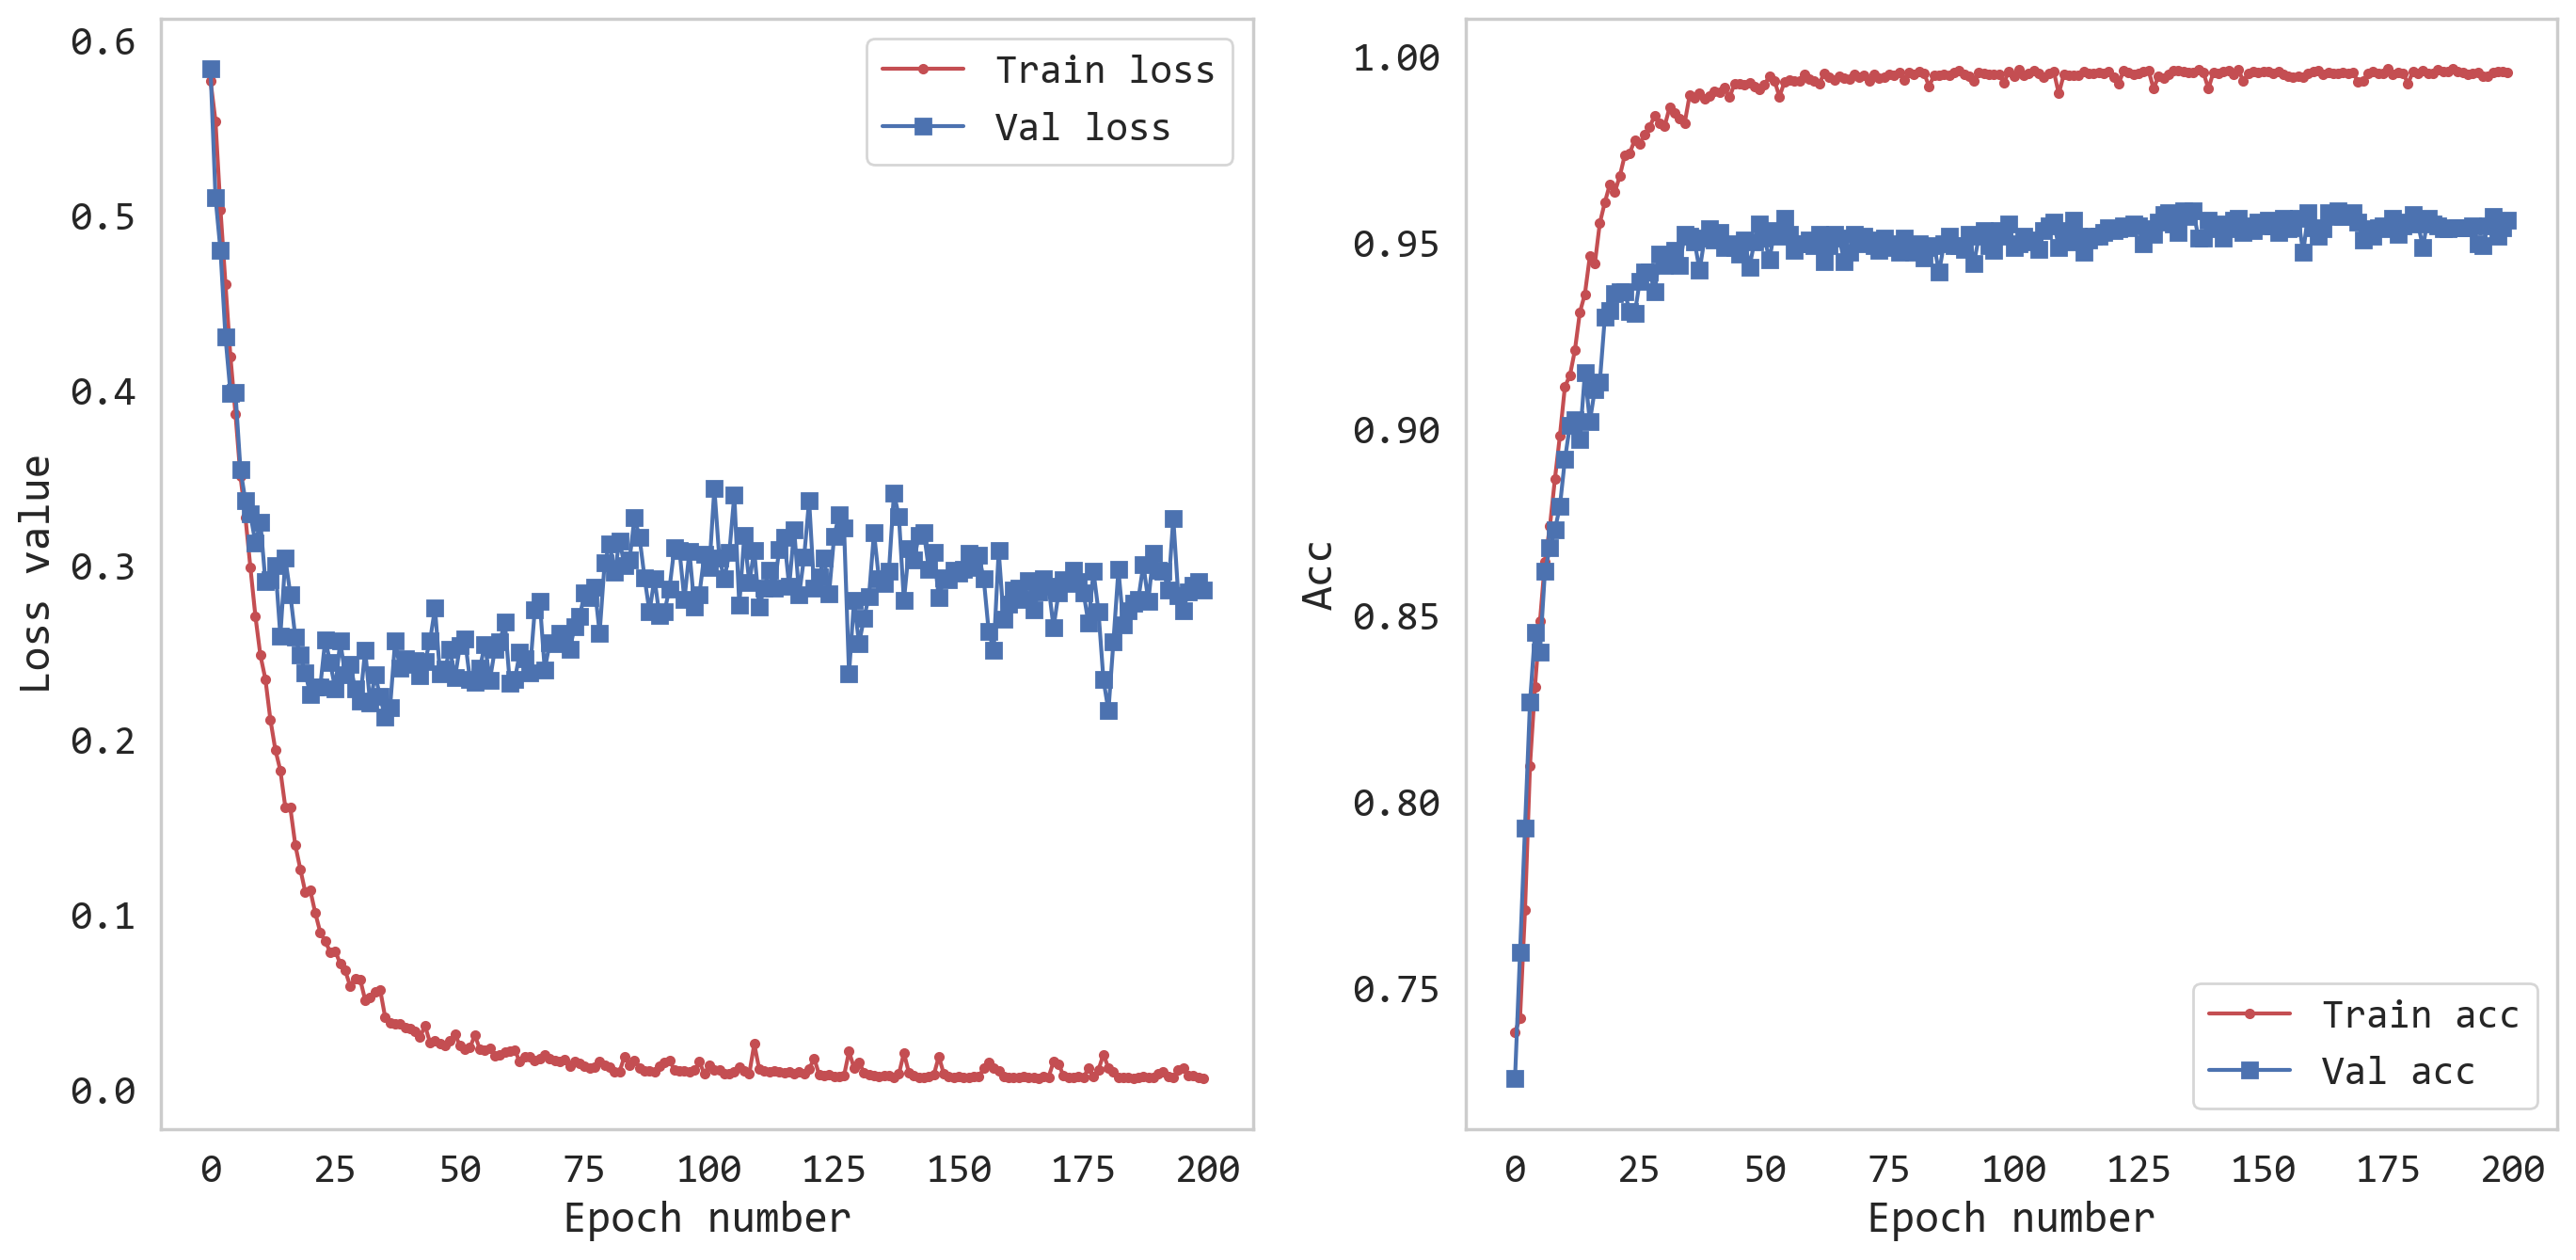

In [14]:
## 可视化模型训练过程
plt.figure(figsize=(14,7))
plt.subplot(1,2,1)
plt.plot(train_process.epoch,train_process.train_loss_all,
         "r.-",label = "Train loss")
plt.plot(train_process.epoch,train_process.val_loss_all,
         "bs-",label = "Val loss")
plt.legend()
plt.grid()
plt.xlabel("Epoch number")
plt.ylabel("Loss value")
plt.subplot(1,2,2)
plt.plot(train_process.epoch,train_process.train_acc_all,
         "r.-",label = "Train acc")
plt.plot(train_process.epoch,train_process.val_acc_all,
         "bs-",label = "Val acc")
plt.xlabel("Epoch number")
plt.ylabel("Acc")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

Accuracy: 0.8977418400552214
Precision: 0.915957214581969
Recall: 0.9691650306039958
F1: 0.9418102238931597
AUC: 0.7247984397284486


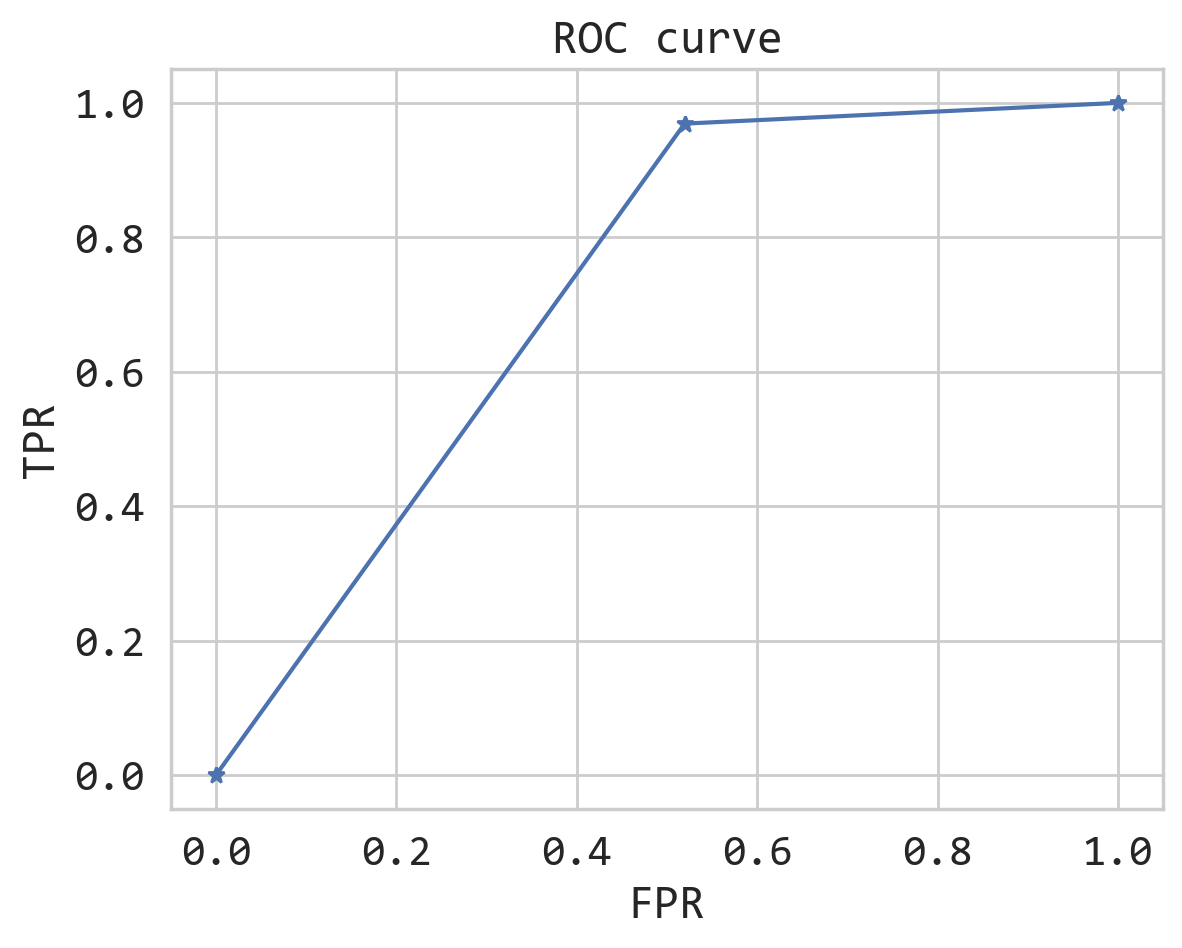

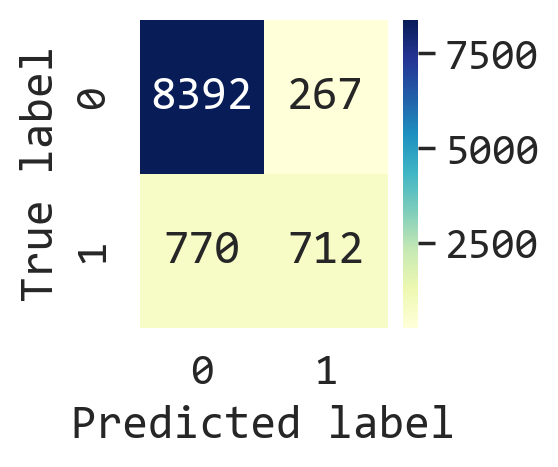

In [15]:
## 对测试集进行预测并计算各项指标
lstmmodel.eval() ## 设置模型为训练模式评估模式 
test_y_all = torch.LongTensor()
pre_lab_all = torch.LongTensor()
for step,batch in enumerate(test_iter):
    textdata,target = batch.cutword[0],batch.labelcode.view(-1)
    hypothesis = lstmmodel(textdata)
    pre_lab = torch.argmax(hypothesis,1)
    test_y_all = torch.cat((test_y_all,target)) ##测试集的标签
    pre_lab_all = torch.cat((pre_lab_all,pre_lab))##测试集的预测标签

## 将真0假1转变为真1假0，以便于调用函数
y_test = []
y_pre = []
for i in test_y_all.detach().numpy():
    if i == 1:
        y_test.append(0)
    else:
        y_test.append(1)
for i in pre_lab_all.detach().numpy():
    if i == 1:
        y_pre.append(0)
    else:
        y_pre.append(1)
        

# Accuracy
# Precision
# Recall
# F1
acc = accuracy_score(y_test,y_pre)
pre = precision_score(y_test,y_pre)
rec = recall_score(y_test,y_pre)
f1  = f1_score(y_test,y_pre)
print("Accuracy:",acc)
print("Precision:",pre)
print("Recall:",rec)
print("F1:",f1)


# ROC曲线
# AUC
## 绘制ROC曲线并且计算AUV值
fpr, tpr, thresholds = roc_curve(y_test,y_pre)
roc_auc = auc(fpr,tpr)
print("AUC:",roc_auc)
plt.plot(fpr,tpr,'*-')
plt.ylabel('TPR')
plt.xlabel('FPR')
plt.title('ROC curve')

## 计算混淆矩阵并可视化
conf_mat = confusion_matrix(test_y_all.detach().numpy(),pre_lab_all.detach().numpy())
plt.figure(figsize = (2,2))
heatmap = sns.heatmap(conf_mat, annot=True, fmt="d",cmap="YlGnBu")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()